In [ ]:
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
import numpy as np
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy(policy="mixed_float16")
from sklearn.model_selection import train_test_split

In [ ]:
data, ds_info = tfds.load(name="food101", # target dataset to get from TFDS
                          split=["validation"], # what splits of data should we get? note: not all datasets have train, valid, test
                          as_supervised=True, # download data in tuple format (sample, label), e.g. (image, label)
                          with_info=True) # ds_info

ds_info.features

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

KeyboardInterrupt: ignored

In [ ]:
class_names = ds_info.features["label"].names
len(class_names)

101

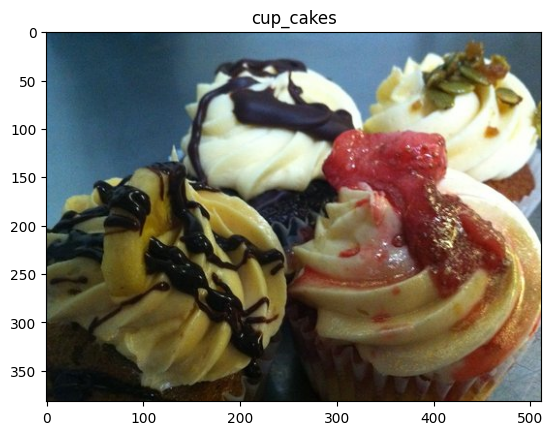

In [ ]:
sample = data[0].take(1)
for image, label in sample:
    plt.imshow(image)
    plt.title(class_names[label])

In [ ]:
images, labels = [], []
for image, label in list(data[0].take(5000).as_numpy_iterator()):
    images.append(image)
    labels.append(label)

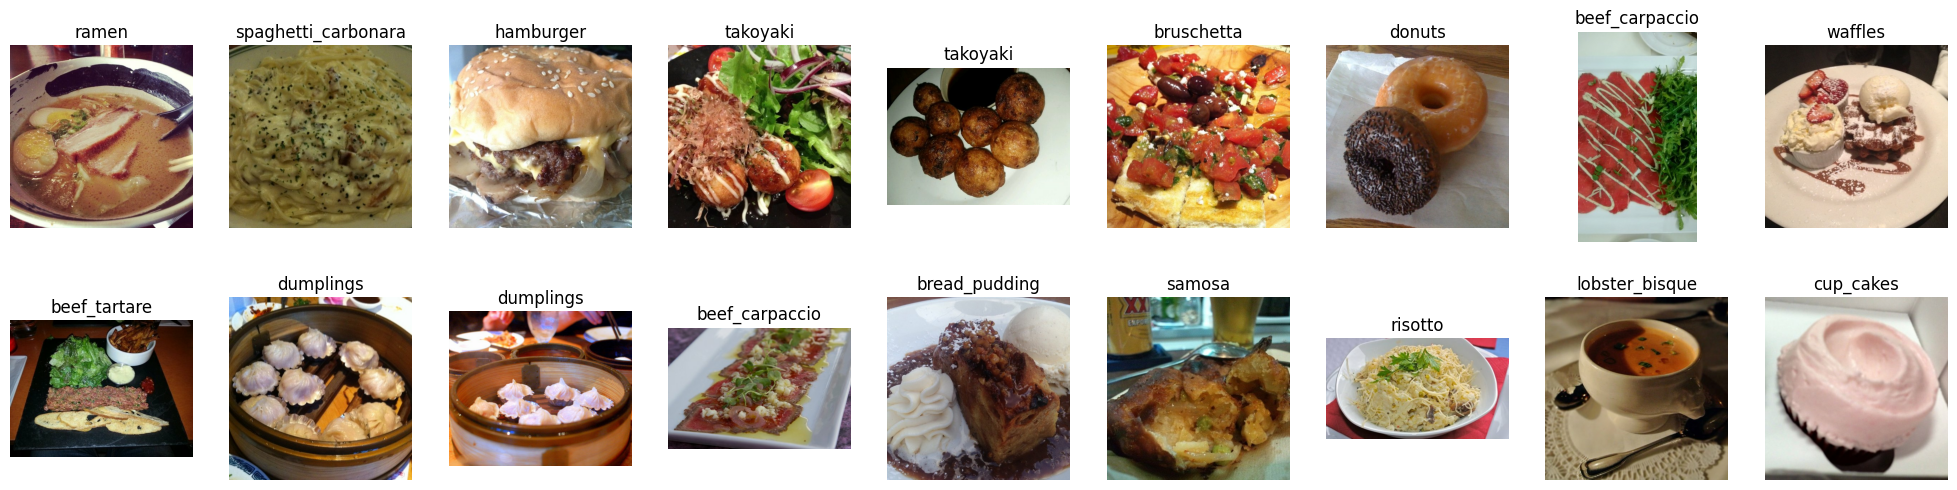

In [ ]:
def plot_images(images, labels, column=9, row=2, w=25, h=6):
    fig = plt.figure(figsize=(w, h))
    columns = column
    rows = row
    for i in range(1, columns*rows +1):
        img = images[i]
        fig.add_subplot(rows, columns, i)
        plt.imshow(img)
        plt.title(class_names[labels[i]])
        plt.axis(False)
    plt.show()

plot_images(images, labels)

In [ ]:
import pickle

def save_list(data, name):
    with open(name, "wb") as fp:   #Pickling
        pickle.dump(data, fp)

def load_list(file_name):
    with open(file_name, "rb") as fp:   # Unpickling
        b = pickle.load(fp)
        return b

# labels = load_list('Labels')

In [ ]:
def preprocess_images(images, img_shape=224):
    pimgs = []
    for image in images:
        pimgs.append(tf.image.resize(image, [img_shape, img_shape]))
    return pimgs

processed_images = preprocess_images(images)

In [ ]:
imgs = tf.convert_to_tensor(processed_images, dtype=tf.float32)
labell = np.array(labels)

split_id = int(0.8*len(imgs))
X_train, X_test = imgs[:split_id], imgs[split_id:]
y_train, y_test = labell[:split_id], labell[split_id:]

In [ ]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

(TensorShape([4000, 224, 224, 3]),
 TensorShape([1000, 224, 224, 3]),
 (4000,),
 (1000,))

In [ ]:
from tensorflow.keras import layers


input_shape = (224, 224, 3)
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False


inputs = layers.Input(shape=input_shape, name="input_layer")

x = base_model(inputs, training=False)
x = layers.GlobalAveragePooling2D(name="pooling_layer")(x)
x = layers.Dense(len(class_names))(x)
outputs = layers.Activation("softmax", dtype=tf.float32, name="softmax_float32")(x)

model = tf.keras.Model(inputs, outputs)

model.compile(loss="sparse_categorical_crossentropy", # Use sparse_categorical_crossentropy when labels are *not* one-hot
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

In [ ]:
model.summary()

In [ ]:
tf.get_logger().setLevel('ERROR')


history_101_food_classes_feature_extract = model.fit(X_train,
                                                     y_train,
                                                     epochs=20,
                                                     steps_per_epoch=len(X_train),
                                                     validation_data=(X_test, y_test))

Epoch 1/20
4000/4000 [==============================] - 64s 14ms/step - loss: 2.3268 - accuracy: 0.4350 - val_loss: 1.7605 - val_accuracy: 0.5380
Epoch 2/20
4000/4000 [==============================] - 49s 12ms/step - loss: 0.8132 - accuracy: 0.7812 - val_loss: 1.8036 - val_accuracy: 0.5500
Epoch 3/20
4000/4000 [==============================] - 53s 13ms/step - loss: 0.3984 - accuracy: 0.8980 - val_loss: 1.7696 - val_accuracy: 0.5640
Epoch 4/20
4000/4000 [==============================] - 50s 12ms/step - loss: 0.1938 - accuracy: 0.9668 - val_loss: 1.8989 - val_accuracy: 0.5730
Epoch 5/20
4000/4000 [==============================] - 50s 12ms/step - loss: 0.0988 - accuracy: 0.9860 - val_loss: 1.9445 - val_accuracy: 0.5630
Epoch 6/20
4000/4000 [==============================] - 51s 13ms/step - loss: 0.0540 - accuracy: 0.9958 - val_loss: 2.0390 - val_accuracy: 0.5680
Epoch 7/20
4000/4000 [==============================] - 51s 13ms/step - loss: 0.0326 - accuracy: 0.9983 - val_loss: 2.1656 -

In [ ]:
y_true = y_test
y_pred = model.predict(X_test).argmax(axis=1)
evaluate_classification_metrics(y_true, y_pred)

32/32 [==============================] - 3s 40ms/step


{'Accuracy': 0.58,
 'Precision': 0.5994018898456205,
 'Recall': 0.58,
 'F1 Score': 0.5753576503702993}

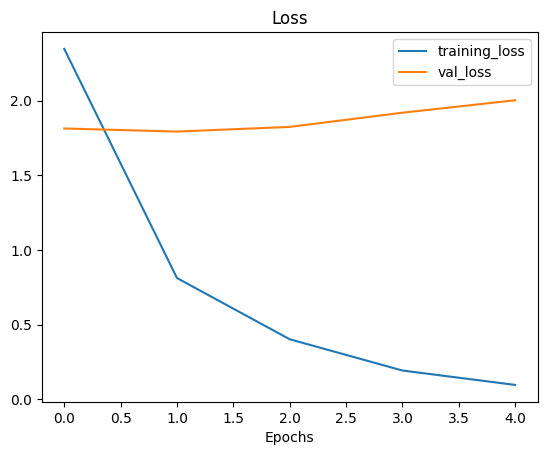

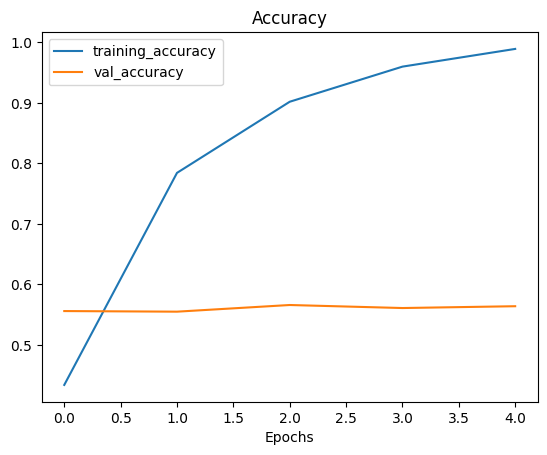

In [ ]:
import matplotlib.pyplot as plt
def plot_loss_curves(history):
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']

    epochs = range(len(loss))
    fig = plt.figure(figsize=(20,10))

    plt.plot(epochs, loss, label='training_loss')
    plt.plot(epochs, val_loss, label='val_loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.legend()

    plt.figure()
    plt.plot(epochs, accuracy, label='training_accuracy')
    plt.plot(epochs, val_accuracy, label='val_accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.legend();
plot_loss_curves(history_101_food_classes_feature_extract)

## CNN Model

In [ ]:
def prepare_data(data, items=5000):
    images, labels = [], []
    for image, label in list(data[0].take(items).as_numpy_iterator()):
        images.append(image)
        labels.append(label)

    def preprocess_images(images, img_shape=224):
        pimgs = []
        for image in images:
            pimgs.append(tf.image.resize(image, [img_shape, img_shape]))
        return pimgs

    processed_images = preprocess_images(images)

    imgs = tf.convert_to_tensor(processed_images, dtype=tf.float32)
    labell = np.array(labels)

    split_id = int(0.8*len(imgs))
    X_train, X_test = imgs[:split_id], imgs[split_id:]
    y_train, y_test = labell[:split_id], labell[split_id:]
    print(f"Data Shapes : X_train:{X_train.shape}, X_test:{X_test.shape}, y_train:{y_train.shape}, y_test:{y_test.shape}")
    return X_train, X_test, y_train, y_test

In [ ]:
X_train, X_test, y_train, y_test = prepare_data(data, 5000)

Data Shapes : X_train:(4000, 224, 224, 3), X_test:(1000, 224, 224, 3), y_train:(4000,), y_test:(1000,)


In [ ]:
cnn_model = tf.keras.Sequential([
  tf.keras.layers.Conv2D(filters=20,
                         kernel_size=3,
                         activation="relu",
                         input_shape=(224, 224, 3)),
  tf.keras.layers.MaxPool2D(pool_size=2, padding="valid"),
  tf.keras.layers.Conv2D(20, 3, activation="relu"),
  tf.keras.layers.MaxPool2D(2),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(101, activation='softmax')
])

cnn_model.compile(optimizer=tf.keras.optimizers.Adam(),
                     loss="sparse_categorical_crossentropy",
                     metrics=['accuracy'])

cnn_history = cnn_model.fit(X_train, y_train, epochs=5,
                            steps_per_epoch=len(X_train),
                            validation_data=(X_test, y_test))

Epoch 1/5
4000/4000 [==============================] - 24s 6ms/step - loss: 8.3684 - accuracy: 0.0080 - val_loss: 4.6175 - val_accuracy: 0.0140
Epoch 2/5
4000/4000 [==============================] - 23s 6ms/step - loss: 4.5699 - accuracy: 0.0358 - val_loss: 4.6263 - val_accuracy: 0.0130
Epoch 3/5
4000/4000 [==============================] - 23s 6ms/step - loss: 4.3216 - accuracy: 0.0925 - val_loss: 5.1085 - val_accuracy: 0.0170
Epoch 4/5
4000/4000 [==============================] - 23s 6ms/step - loss: 3.9919 - accuracy: 0.1760 - val_loss: 5.6528 - val_accuracy: 0.0180
Epoch 5/5
4000/4000 [==============================] - 23s 6ms/step - loss: 3.6462 - accuracy: 0.2570 - val_loss: 8.9586 - val_accuracy: 0.0180


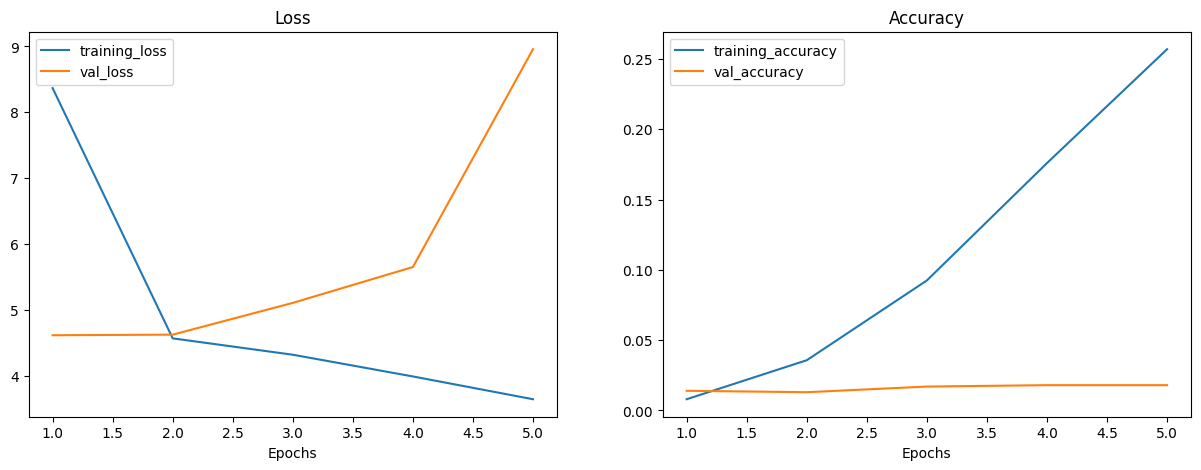

In [ ]:
import matplotlib.pyplot as plt
def plot_loss_curves(history):
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']

    epochs = range(1, 1+len(loss))
    fig = plt.figure(figsize=(15,5))

    fig.add_subplot(1, 2, 1)
    plt.plot(epochs, loss, label='training_loss')
    plt.plot(epochs, val_loss, label='val_loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.legend()

    fig.add_subplot(1, 2, 2)
    plt.plot(epochs, accuracy, label='training_accuracy')
    plt.plot(epochs, val_accuracy, label='val_accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.legend();
    plt.show()
plot_loss_curves(cnn_history)

In [ ]:
cnn_model_2 = tf.keras.Sequential([
  tf.keras.layers.Conv2D(filters=20,
                         kernel_size=3,
                         activation="relu",
                         input_shape=(224, 224, 3)),
  tf.keras.layers.Conv2D(20, 3, activation="relu"),
  tf.keras.layers.MaxPool2D(pool_size=2, padding="valid"),
  tf.keras.layers.Conv2D(20, 3, activation="relu"),
  tf.keras.layers.Conv2D(20, 3, activation="relu"),
  tf.keras.layers.MaxPool2D(2),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(101, activation='softmax')
])

cnn_model_2.compile(optimizer=tf.keras.optimizers.Adam(),
                     loss="sparse_categorical_crossentropy",
                     metrics=['accuracy'])

cnn_history_2 = cnn_model_2.fit(X_train, y_train, epochs=20,
                            steps_per_epoch=len(X_train),
                            validation_data=(X_test, y_test))

Epoch 1/20
4000/4000 [==============================] - 46s 9ms/step - loss: 5.0340 - accuracy: 0.0093 - val_loss: 4.6211 - val_accuracy: 0.0110
Epoch 2/20
4000/4000 [==============================] - 35s 9ms/step - loss: 4.6133 - accuracy: 0.0130 - val_loss: 4.6213 - val_accuracy: 0.0140
Epoch 3/20
4000/4000 [==============================] - 39s 10ms/step - loss: 4.6097 - accuracy: 0.0140 - val_loss: 4.6231 - val_accuracy: 0.0140
Epoch 4/20
4000/4000 [==============================] - 26s 7ms/step - loss: 4.6097 - accuracy: 0.0135 - val_loss: 4.6243 - val_accuracy: 0.0140
Epoch 5/20
4000/4000 [==============================] - 27s 7ms/step - loss: 4.6093 - accuracy: 0.0127 - val_loss: 4.6252 - val_accuracy: 0.0140
Epoch 6/20
4000/4000 [==============================] - 27s 7ms/step - loss: 4.6091 - accuracy: 0.0117 - val_loss: 4.6265 - val_accuracy: 0.0140
Epoch 7/20
4000/4000 [==============================] - 28s 7ms/step - loss: 4.6090 - accuracy: 0.0135 - val_loss: 4.6266 - val_a

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, log_loss, confusion_matrix, roc_auc_score
import numpy as np

def evaluate_classification_metrics(y_true, y_pred):
    # Calculate metrics
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    f1 = f1_score(y_true, y_pred, average='weighted')

    return {
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1
    }


y_true = y_test
y_pred = cnn_model_2.predict(X_test).argmax(axis=1)
evaluate_classification_metrics(y_true, y_pred)

32/32 [==============================] - 1s 17ms/step


{'Accuracy': 0.01,
 'Precision': 0.007559032634032635,
 'Recall': 0.01,
 'F1 Score': 0.007438136288998359}

In [ ]:
from sklearn import metrics
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix)

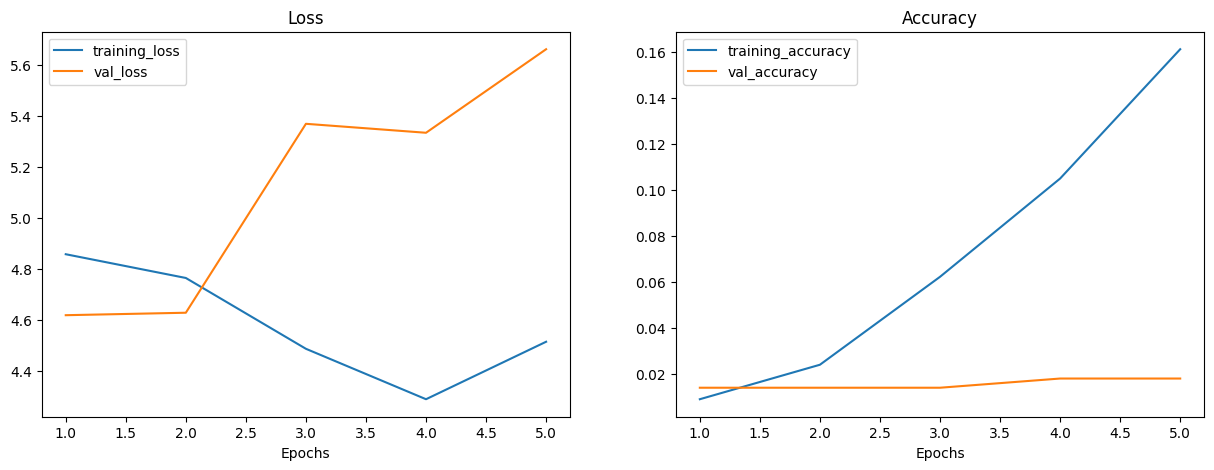

In [ ]:
plot_loss_curves(cnn_history_2)

In [ ]:
cnn_model_3 = tf.keras.Sequential([
  tf.keras.layers.Conv2D(20, 3, activation="relu"),
  tf.keras.layers.MaxPool2D(2),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(64),
  tf.keras.layers.Dense(64),
  tf.keras.layers.Dense(101, activation='softmax')
])

cnn_model_3.compile(optimizer=tf.keras.optimizers.Adam(),
                     loss="sparse_categorical_crossentropy",
                     metrics=['accuracy'])

cnn_history_3 = cnn_model_3.fit(X_train, y_train, epochs=5,
                            steps_per_epoch=len(X_train),
                            validation_data=(X_test, y_test))

Epoch 1/5
4000/4000 [==============================] - 38s 9ms/step - loss: 54.6584 - accuracy: 0.0103 - val_loss: 4.7082 - val_accuracy: 0.0120
Epoch 2/5
4000/4000 [==============================] - 36s 9ms/step - loss: 3.0935 - accuracy: 0.3952 - val_loss: 6.3495 - val_accuracy: 0.0120
Epoch 3/5
4000/4000 [==============================] - 36s 9ms/step - loss: 2.2713 - accuracy: 0.6220 - val_loss: 11.3744 - val_accuracy: 0.0140
Epoch 4/5
4000/4000 [==============================] - 36s 9ms/step - loss: 2.3794 - accuracy: 0.6455 - val_loss: 15.9214 - val_accuracy: 0.0110
Epoch 5/5
4000/4000 [==============================] - 36s 9ms/step - loss: 2.0977 - accuracy: 0.6917 - val_loss: 21.5354 - val_accuracy: 0.0130


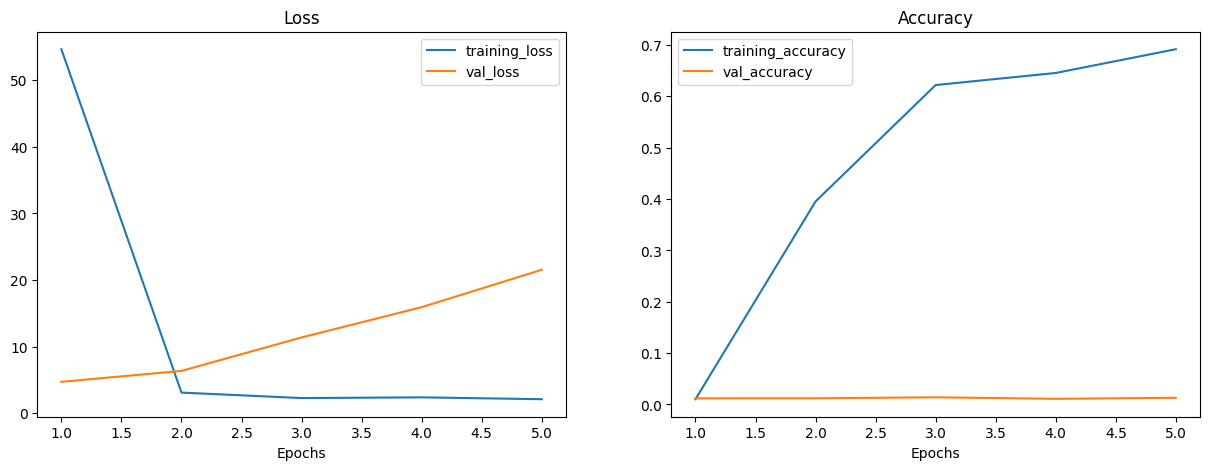

In [ ]:
plot_loss_curves(cnn_history_3)

In [ ]:
cnn_model_4 = tf.keras.Sequential([
  tf.keras.layers.Conv2D(20, 3, activation="relu"),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(64),
  tf.keras.layers.Dense(101, activation='softmax')
])

cnn_model_4.compile(optimizer=tf.keras.optimizers.Adam(),
                     loss="sparse_categorical_crossentropy",
                     metrics=['accuracy'])

cnn_history_4 = cnn_model_4.fit(X_train, y_train, epochs=5,
                            steps_per_epoch=len(X_train),
                            validation_data=(X_test, y_test))

Epoch 1/5
4000/4000 [==============================] - 101s 25ms/step - loss: nan - accuracy: 0.0080 - val_loss: 5.1929 - val_accuracy: 0.0070
Epoch 2/5
4000/4000 [==============================] - 100s 25ms/step - loss: 1.8318 - accuracy: 0.7035 - val_loss: 12.9403 - val_accuracy: 0.0140
Epoch 3/5
4000/4000 [==============================] - 100s 25ms/step - loss: 1.0872 - accuracy: 0.8347 - val_loss: 15.9353 - val_accuracy: 0.0130
Epoch 4/5
4000/4000 [==============================] - 101s 25ms/step - loss: 0.9021 - accuracy: 0.8892 - val_loss: 18.8796 - val_accuracy: 0.0150
Epoch 5/5
4000/4000 [==============================] - 101s 25ms/step - loss: 0.6431 - accuracy: 0.9103 - val_loss: 35.7630 - val_accuracy: 0.0190


## LSTM Model

In [ ]:
def prepare_data_sequential(data, items=5000):
    images, labels = [], []
    for image, label in list(data[0].take(items).as_numpy_iterator()):
        images.append(image)
        labels.append(label)

    def preprocess_images(images, img_shape=224):
        pimgs = []
        for image in images:
            tmp = tf.image.resize(image, [img_shape, img_shape]).numpy()
            tmp = np.dot(tmp[...,:3], [0.2989, 0.5870, 0.1140])
            pimgs.append(tmp)
        return pimgs

    processed_images = preprocess_images(images)

    imgs = tf.convert_to_tensor(processed_images, dtype=tf.float32)
    labels = pd.get_dummies(labels)
    labell = np.array(labels)

    split_id = int(0.8*len(imgs))
    X_train, X_test = imgs[:split_id], imgs[split_id:]
    y_train, y_test = labell[:split_id], labell[split_id:]
    print(f"Data Shapes : X_train:{X_train.shape}, X_test:{X_test.shape}, y_train:{y_train.shape}, y_test:{y_test.shape}")
    return X_train, X_test, y_train, y_test

In [ ]:
X_train, X_test, y_train, y_test = prepare_data_sequential(data, items=5000)

Data Shapes : X_train:(4000, 224, 224), X_test:(1000, 224, 224), y_train:(4000, 101), y_test:(1000, 101)


In [ ]:
lstm_model_1 = tf.keras.Sequential([
    # tf.keras.layers.LSTM(64, return_sequences=True),
    tf.keras.layers.LSTM(64),
    tf.keras.layers.Dense(256, 'relu'),
    # tf.keras.layers.Dense(256, 'relu'),
    # tf.keras.layers.Dense(256, 'relu'),
    tf.keras.layers.Dense(101, 'softmax')
])

lstm_model_1.compile(optimizer=tf.keras.optimizers.Adam(),
                     loss="categorical_crossentropy",
                     metrics=['accuracy'])

lstm_history_1 = lstm_model_1.fit(X_train, y_train, epochs=5,
                            steps_per_epoch=len(X_train),
                            validation_data=(X_test, y_test))

Epoch 1/5
4000/4000 [==============================] - 51s 10ms/step - loss: 4.6400 - accuracy: 0.0113 - val_loss: 4.6223 - val_accuracy: 0.0140
Epoch 2/5
4000/4000 [==============================] - 40s 10ms/step - loss: 4.6179 - accuracy: 0.0110 - val_loss: 4.6281 - val_accuracy: 0.0150
Epoch 3/5
4000/4000 [==============================] - 39s 10ms/step - loss: 4.6166 - accuracy: 0.0143 - val_loss: 4.6421 - val_accuracy: 0.0130
Epoch 4/5
4000/4000 [==============================] - 39s 10ms/step - loss: 4.6137 - accuracy: 0.0150 - val_loss: 4.6593 - val_accuracy: 0.0140
Epoch 5/5
4000/4000 [==============================] - 39s 10ms/step - loss: 4.6098 - accuracy: 0.0127 - val_loss: 4.6450 - val_accuracy: 0.0090


In [ ]:
lstm_model_1 = tf.keras.Sequential([
    tf.keras.layers.LSTM(64, return_sequences=True),
    tf.keras.layers.LSTM(64),
    tf.keras.layers.Dense(256, 'relu'),
    tf.keras.layers.Dense(256, 'relu'),
    tf.keras.layers.Dense(256, 'relu'),
    tf.keras.layers.Dense(101, 'softmax')
])

lstm_model_1.compile(optimizer=tf.keras.optimizers.Adam(),
                     loss="categorical_crossentropy",
                     metrics=['accuracy'])

lstm_history_1 = lstm_model_1.fit(X_train, y_train, epochs=20,
                            steps_per_epoch=len(X_train),
                            validation_data=(X_test, y_test))

Epoch 1/20
4000/4000 [==============================] - 73s 17ms/step - loss: 4.6213 - accuracy: 0.0090 - val_loss: 4.6160 - val_accuracy: 0.0140
Epoch 2/20
4000/4000 [==============================] - 65s 16ms/step - loss: 4.6127 - accuracy: 0.0132 - val_loss: 4.6189 - val_accuracy: 0.0140
Epoch 3/20
4000/4000 [==============================] - 66s 16ms/step - loss: 4.6106 - accuracy: 0.0130 - val_loss: 4.6213 - val_accuracy: 0.0140
Epoch 4/20
4000/4000 [==============================] - 65s 16ms/step - loss: 4.6097 - accuracy: 0.0137 - val_loss: 4.6233 - val_accuracy: 0.0140
Epoch 5/20
4000/4000 [==============================] - 65s 16ms/step - loss: 4.6093 - accuracy: 0.0127 - val_loss: 4.6244 - val_accuracy: 0.0140
Epoch 6/20
4000/4000 [==============================] - 65s 16ms/step - loss: 4.6091 - accuracy: 0.0130 - val_loss: 4.6267 - val_accuracy: 0.0140
Epoch 7/20
4000/4000 [==============================] - 65s 16ms/step - loss: 4.6090 - accuracy: 0.0122 - val_loss: 4.6271 -

In [ ]:
cnn_model_2 = tf.keras.Sequential([
#   tf.keras.layers.Conv2D(filters=20,
#                          kernel_size=3,
#                          activation="relu"),
#   tf.keras.layers.Conv2D(20, 3, activation="relu"),
#   tf.keras.layers.MaxPool2D(pool_size=2, padding="valid"),
#   tf.keras.layers.Conv2D(20, 3, activation="relu"),
#   tf.keras.layers.Conv2D(20, 3, activation="relu"),
#   tf.keras.layers.MaxPool2D(2),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(64),
  tf.keras.layers.Dense(64),
  tf.keras.layers.Dense(101, activation='softmax')
])

cnn_model_2.compile(optimizer=tf.keras.optimizers.Adam(),
                     loss="categorical_crossentropy",
                     metrics=['accuracy'])

cnn_history_2 = cnn_model_2.fit(X_train, y_train, epochs=20,
                            steps_per_epoch=len(X_train),
                            validation_data=(X_test, y_test))

Epoch 1/20
4000/4000 [==============================] - 23s 5ms/step - loss: 8273.2324 - accuracy: 0.0093 - val_loss: inf - val_accuracy: 0.0110
Epoch 2/20
4000/4000 [==============================] - 19s 5ms/step - loss: 2379.7090 - accuracy: 0.0155 - val_loss: inf - val_accuracy: 0.0110
Epoch 3/20
4000/4000 [==============================] - 20s 5ms/step - loss: 1130.8691 - accuracy: 0.0110 - val_loss: 396.2760 - val_accuracy: 0.0130
Epoch 4/20
4000/4000 [==============================] - 21s 5ms/step - loss: 252.6855 - accuracy: 0.0148 - val_loss: 86.6915 - val_accuracy: 0.0120
Epoch 5/20
4000/4000 [==============================] - 20s 5ms/step - loss: nan - accuracy: 0.0115 - val_loss: 60.1675 - val_accuracy: 0.0110
Epoch 6/20
4000/4000 [==============================] - 19s 5ms/step - loss: nan - accuracy: 0.0108 - val_loss: 54.1915 - val_accuracy: 0.0120
Epoch 7/20
4000/4000 [==============================] - 19s 5ms/step - loss: nan - accuracy: 0.0105 - val_loss: 136.3300 - val

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers

# Load and preprocess the CIFAR-10 dataset
x_train, y_train, x_test, y_test = X_train, y_train, X_test, y_test
x_train, x_test = x_train / 255.0, x_test / 255.0

# Define the transformer block
class TransformerBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super(TransformerBlock, self).__init__()
        self.att = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = tf.keras.Sequential(
            [layers.Dense(ff_dim, activation="relu"), layers.Dense(embed_dim),]
        )
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)

    def call(self, inputs, training):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

# Define the model
inputs = layers.Input(shape=(224, 224, 3))
x = layers.Conv2D(32, 3, activation="relu")(inputs)
x = layers.MaxPooling2D()(x)
x = layers.Conv2D(64, 3, activation="relu")(x)
x = layers.MaxPooling2D()(x)
x = layers.Reshape((-1, 64))(x)
x = TransformerBlock(64, 2, 32)(x)
x = layers.GlobalAveragePooling1D()(x)
outputs = layers.Dense(101, activation="softmax")(x)

model = tf.keras.Model(inputs=inputs, outputs=outputs)

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(x_train, y_train, epochs=20, validation_data=(x_test, y_test))

# Evaluate the model
y_true = y_test
y_pred = model.predict(X_test).argmax(axis=1)
evaluate_classification_metrics(y_true, y_pred)

Epoch 1/20
125/125 [==============================] - 43s 288ms/step - loss: 4.7003 - accuracy: 0.0088 - val_loss: 4.6442 - val_accuracy: 0.0140
Epoch 2/20
125/125 [==============================] - 32s 258ms/step - loss: 4.6221 - accuracy: 0.0113 - val_loss: 4.6148 - val_accuracy: 0.0170
Epoch 3/20
125/125 [==============================] - 35s 279ms/step - loss: 4.5537 - accuracy: 0.0180 - val_loss: 4.5697 - val_accuracy: 0.0150
Epoch 4/20
125/125 [==============================] - 33s 262ms/step - loss: 4.4851 - accuracy: 0.0280 - val_loss: 4.4894 - val_accuracy: 0.0360
Epoch 5/20
125/125 [==============================] - 32s 260ms/step - loss: 4.4012 - accuracy: 0.0367 - val_loss: 4.3872 - val_accuracy: 0.0620
Epoch 6/20
125/125 [==============================] - 35s 276ms/step - loss: 4.3208 - accuracy: 0.0468 - val_loss: 4.3424 - val_accuracy: 0.0460
Epoch 7/20
125/125 [==============================] - 34s 275ms/step - loss: 4.2432 - accuracy: 0.0540 - val_loss: 4.3274 - val_ac

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'Accuracy': 0.007,
 'Precision': 4.954499494438827e-05,
 'Recall': 0.007,
 'F1 Score': 9.839357429718876e-05}

In [ ]:
y_true = y_test
y_pred = model.predict(X_test).argmax(axis=1)
evaluate_classification_metrics(y_true, y_pred)
y_pred, y_test

32/32 [==============================] - 3s 93ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


(array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0, 12,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, 12,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0, 12,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0, 

In [ ]:
x_train, y_train, x_test, y_test = X_train, y_train, X_test, y_test
x_train, x_test = x_train / 255.0, x_test / 255.0

cnn_model_2 = tf.keras.Sequential([
  tf.keras.layers.Conv2D(filters=32,
                         kernel_size=3,
                         activation="relu",
                         input_shape=(224, 224, 3)),
#   tf.keras.layers.Conv2D(20, 3, activation="relu"),
  tf.keras.layers.MaxPool2D(),
  tf.keras.layers.Conv2D(64, 3, activation="relu"),
#   tf.keras.layers.Conv2D(20, 3, activation="relu"),
  tf.keras.layers.MaxPool2D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(64),
  tf.keras.layers.Dropout(0.5),
  tf.keras.layers.Dense(101, activation='softmax')
])

cnn_model_2.compile(optimizer=tf.keras.optimizers.Adam(),
                     loss="sparse_categorical_crossentropy",
                     metrics=['accuracy'])

cnn_history_2 = cnn_model_2.fit(x_train, y_train, epochs=10,
                            steps_per_epoch=len(X_train),
                            validation_data=(x_test, y_test))

Epoch 1/10
4000/4000 [==============================] - 43s 10ms/step - loss: 4.6962 - accuracy: 0.0093 - val_loss: 4.6198 - val_accuracy: 0.0140
Epoch 2/10
4000/4000 [==============================] - 35s 9ms/step - loss: 4.6143 - accuracy: 0.0140 - val_loss: 4.6168 - val_accuracy: 0.0140
Epoch 3/10
4000/4000 [==============================] - 35s 9ms/step - loss: 4.3440 - accuracy: 0.0712 - val_loss: 4.6919 - val_accuracy: 0.0220
Epoch 4/10
4000/4000 [==============================] - 34s 9ms/step - loss: 3.4707 - accuracy: 0.2415 - val_loss: 5.4097 - val_accuracy: 0.0230
Epoch 5/10
4000/4000 [==============================] - 35s 9ms/step - loss: 2.5511 - accuracy: 0.4270 - val_loss: 6.5206 - val_accuracy: 0.0190
Epoch 6/10
4000/4000 [==============================] - 34s 8ms/step - loss: 1.9318 - accuracy: 0.5775 - val_loss: 7.5320 - val_accuracy: 0.0160
Epoch 7/10
4000/4000 [==============================] - 35s 9ms/step - loss: 1.5493 - accuracy: 0.6645 - val_loss: 8.1777 - val_a

## Working on 10% of DATA

In [2]:
# Get data (10% of labels)
import zipfile

# Download data
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

# Unzip the downloaded file
zip_ref = zipfile.ZipFile("10_food_classes_10_percent.zip", "r")
zip_ref.extractall()
zip_ref.close()

--2023-11-27 14:08:16--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.2.207, 2607:f8b0:4023:c0b::cf, 2607:f8b0:4023:c0d::cf
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.2.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M   276MB/s    in 0.6s    

2023-11-27 14:08:17 (276 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



In [3]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMAGE_SHAPE = (224, 224)
BATCH_SIZE = 32

train_dir = "10_food_classes_10_percent/train/"
test_dir = "10_food_classes_10_percent/test/"

train_datagen = ImageDataGenerator(rescale=1/255.)
test_datagen = ImageDataGenerator(rescale=1/255.)

print("Training images:")
train_data_10_percent = train_datagen.flow_from_directory(train_dir,
                                               target_size=IMAGE_SHAPE,
                                               batch_size=BATCH_SIZE,
                                               class_mode="categorical")

print("Testing images:")
test_data = train_datagen.flow_from_directory(test_dir,
                                              target_size=IMAGE_SHAPE,
                                              batch_size=BATCH_SIZE,
                                              class_mode="categorical")

Training images:
Found 750 images belonging to 10 classes.
Testing images:
Found 2500 images belonging to 10 classes.


In [4]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, log_loss, confusion_matrix, roc_auc_score
import numpy as np

def evaluate_classification_metrics(y_true, y_pred):
    # Calculate metrics
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    f1 = f1_score(y_true, y_pred, average='weighted')

    return {
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1
    }

In [15]:
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers

efficientnet_url = "https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1"

def create_model(model_url, num_classes=10):
  feature_extractor_layer = hub.KerasLayer(model_url,
                                           trainable=False, # freeze the underlying patterns
                                           name='feature_extraction_layer',
                                           input_shape=(224, 224)+(3,)) # define the input image shape

  model = tf.keras.Sequential([
    feature_extractor_layer, # use the feature extraction layer as the base
    layers.Dense(num_classes, activation='softmax', name='output_layer') # create our own output layer
  ])

  return model

efficientnet_model = create_model(model_url=efficientnet_url, # use EfficientNetB0 TensorFlow Hub URL
                                  num_classes=train_data_10_percent.num_classes)

# Compile EfficientNet model
efficientnet_model.compile(loss='categorical_crossentropy',
                           optimizer=tf.keras.optimizers.Adam(),
                           metrics=['accuracy'])

# Fit EfficientNet model
efficientnet_history = efficientnet_model.fit(train_data_10_percent, # only use 10% of training data
                                              epochs=10, # train for 5 epochs
                                              steps_per_epoch=len(train_data_10_percent),
                                              validation_data=test_data,
                                              validation_steps=len(test_data))

X_test, y_test = test_data.next()
evaluate_classification_metrics(y_test.argmax(axis=1), efficientnet_model.predict(X_test).argmax(axis=1))

Epoch 1/10
24/24 [==============================] - 27s 488ms/step - loss: 1.8421 - accuracy: 0.4227 - val_loss: 1.2934 - val_accuracy: 0.7116
Epoch 2/10
24/24 [==============================] - 10s 432ms/step - loss: 1.0746 - accuracy: 0.7667 - val_loss: 0.8735 - val_accuracy: 0.8156
Epoch 3/10
24/24 [==============================] - 12s 536ms/step - loss: 0.7657 - accuracy: 0.8400 - val_loss: 0.7003 - val_accuracy: 0.8452
Epoch 4/10
24/24 [==============================] - 16s 694ms/step - loss: 0.6174 - accuracy: 0.8640 - val_loss: 0.6155 - val_accuracy: 0.8524
Epoch 5/10
24/24 [==============================] - 10s 444ms/step - loss: 0.5201 - accuracy: 0.8920 - val_loss: 0.5615 - val_accuracy: 0.8632
Epoch 6/10
24/24 [==============================] - 9s 396ms/step - loss: 0.4488 - accuracy: 0.9093 - val_loss: 0.5215 - val_accuracy: 0.8680
Epoch 7/10
24/24 [==============================] - 12s 497ms/step - loss: 0.3955 - accuracy: 0.9200 - val_loss: 0.4974 - val_accuracy: 0.8712


{'Accuracy': 0.84375,
 'Precision': 0.9114583333333334,
 'Recall': 0.84375,
 'F1 Score': 0.8587826099339257}

In [21]:
tmp = tf.keras.Sequential([
    hub.KerasLayer(efficientnet_url,
                  trainable=False, # freeze the underlying patterns
                  name='feature_extraction_layer',
                  input_shape=(224, 224)+(3,)),
    layers.Dense(10, activation='softmax', name='output_layer')
])
tmp.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (  (None, 1280)              4049564   
 KerasLayer)                                                     
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4062374 (15.50 MB)
Trainable params: 12810 (50.04 KB)
Non-trainable params: 4049564 (15.45 MB)
_________________________________________________________________


In [17]:
cnn_model = tf.keras.Sequential([
  tf.keras.layers.Conv2D(filters=32,
                         kernel_size=3,
                         activation="relu",
                         input_shape=(224, 224, 3,)),
  tf.keras.layers.Conv2D(32, 3, activation="relu"),
  tf.keras.layers.MaxPool2D(),
  tf.keras.layers.Conv2D(64, 3, activation="relu"),
  tf.keras.layers.Conv2D(64, 3, activation="relu"),
  tf.keras.layers.MaxPool2D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(64),
#   tf.keras.layers.Dropout(0.5),
  tf.keras.layers.Dense(10, activation='softmax')
])

cnn_model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 222, 222, 32)      896       
                                                                 
 conv2d_9 (Conv2D)           (None, 220, 220, 32)      9248      
                                                                 
 max_pooling2d_8 (MaxPoolin  (None, 110, 110, 32)      0         
 g2D)                                                            
                                                                 
 conv2d_10 (Conv2D)          (None, 108, 108, 64)      18496     
                                                                 
 conv2d_11 (Conv2D)          (None, 106, 106, 64)      36928     
                                                                 
 max_pooling2d_9 (MaxPoolin  (None, 53, 53, 64)        0         
 g2D)                                                 

In [5]:
cnn_model = tf.keras.Sequential([
  tf.keras.layers.Conv2D(filters=32,
                         kernel_size=3,
                         activation="relu",
                         input_shape=(224, 224, 3,)),
  tf.keras.layers.Conv2D(32, 3, activation="relu"),
  tf.keras.layers.MaxPool2D(),
  tf.keras.layers.Conv2D(64, 3, activation="relu"),
  tf.keras.layers.Conv2D(64, 3, activation="relu"),
  tf.keras.layers.MaxPool2D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(64),
#   tf.keras.layers.Dropout(0.5),
  tf.keras.layers.Dense(10, activation='softmax')
])

cnn_model.compile(optimizer=tf.keras.optimizers.Adam(),
                     loss="categorical_crossentropy",
                     metrics=['accuracy'])

cnn_history = cnn_model.fit(train_data_10_percent, # only use 10% of training data
                                              epochs=10, # train for 5 epochs
                                              steps_per_epoch=len(train_data_10_percent),
                                              validation_data=test_data,
                                              validation_steps=len(test_data))

evaluate_classification_metrics(y_test.argmax(axis=1), cnn_model.predict(X_test).argmax(axis=1))

Epoch 1/10
24/24 [==============================] - 27s 742ms/step - loss: 3.7558 - accuracy: 0.1147 - val_loss: 2.2934 - val_accuracy: 0.1372
Epoch 2/10
24/24 [==============================] - 10s 416ms/step - loss: 2.2372 - accuracy: 0.1893 - val_loss: 2.2946 - val_accuracy: 0.1336
Epoch 3/10
24/24 [==============================] - 13s 546ms/step - loss: 2.1311 - accuracy: 0.2747 - val_loss: 2.3366 - val_accuracy: 0.1700
Epoch 4/10
24/24 [==============================] - 9s 400ms/step - loss: 1.6039 - accuracy: 0.4440 - val_loss: 2.8654 - val_accuracy: 0.1476
Epoch 5/10
24/24 [==============================] - 10s 427ms/step - loss: 0.9954 - accuracy: 0.6573 - val_loss: 4.4760 - val_accuracy: 0.1472
Epoch 6/10
24/24 [==============================] - 13s 544ms/step - loss: 0.5061 - accuracy: 0.8427 - val_loss: 5.8260 - val_accuracy: 0.1496
Epoch 7/10
24/24 [==============================] - 9s 388ms/step - loss: 0.1864 - accuracy: 0.9320 - val_loss: 6.8330 - val_accuracy: 0.1384
E

{'Accuracy': 0.1875,
 'Precision': 0.19270833333333331,
 'Recall': 0.1875,
 'F1 Score': 0.18489583333333331}

In [5]:
import matplotlib.pyplot as plt
def plot_loss_curves(history):
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']

    epochs = range(len(loss))
    fig = plt.figure(figsize=(6, 5))

    plt.plot(epochs, loss, label='training_loss')
    plt.plot(epochs, val_loss, label='val_loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.grid('on')
    plt.legend()

    plt.figure()
    plt.plot(epochs, accuracy, label='training_accuracy')
    plt.plot(epochs, val_accuracy, label='val_accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.grid('on')
    plt.legend();

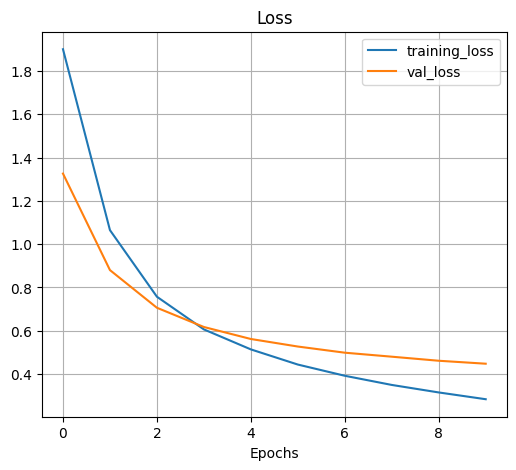

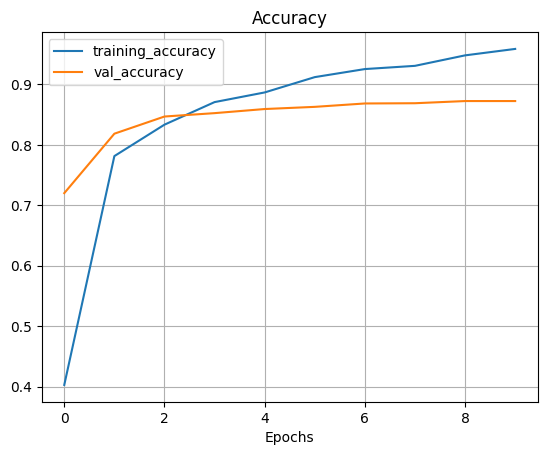

In [23]:
plot_loss_curves(efficientnet_history);

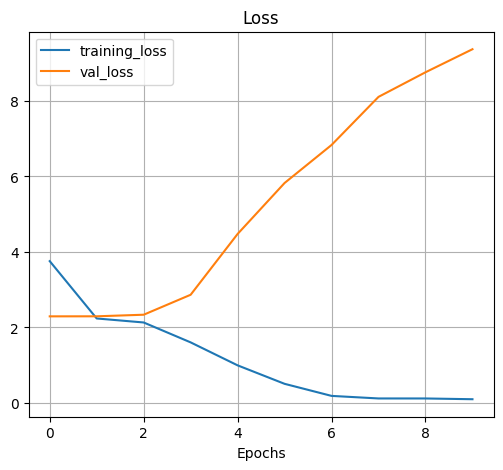

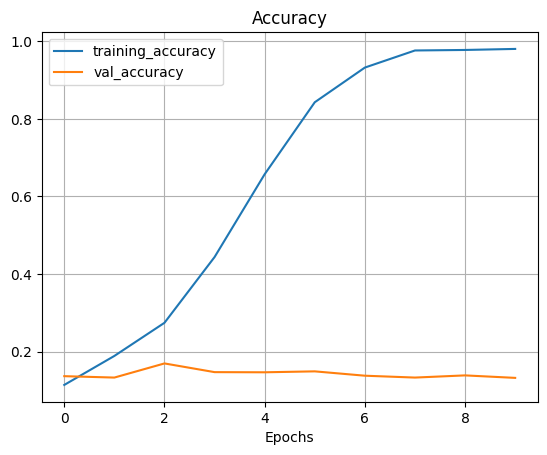

In [24]:
plot_loss_curves(cnn_history);

In [22]:
import tensorflow as tf
from tensorflow.keras import layers, models

def create_lstm_image_model(input_shape, num_classes):
    model = models.Sequential()

    model.add(layers.Reshape((input_shape[0] * input_shape[1], input_shape[2]), input_shape=input_shape))

    model.add(layers.LSTM(128, return_sequences=True))
    model.add(layers.LSTM(64, return_sequences=True))
    model.add(layers.LSTM(32))

    model.add(layers.Dense(128, activation='relu'))
    # model.add(layers.Dropout(0.5))
    model.add(layers.Dense(num_classes, activation='softmax'))

    return model

tmp = create_lstm_image_model((224, 224, 3), 10)
tmp.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape_5 (Reshape)         (None, 50176, 3)          0         
                                                                 
 lstm (LSTM)                 (None, 50176, 128)        67584     
                                                                 
 lstm_1 (LSTM)               (None, 50176, 64)         49408     
                                                                 
 lstm_2 (LSTM)               (None, 32)                12416     
                                                                 
 dense_18 (Dense)            (None, 128)               4224      
                                                                 
 dense_19 (Dense)            (None, 10)                1290      
                                                                 
Total params: 134922 (527.04 KB)
Trainable params: 13

In [5]:
import tensorflow as tf
from tensorflow.keras import layers, models

def create_lstm_image_model(input_shape, num_classes):
    model = models.Sequential()

    model.add(layers.Reshape((input_shape[0] * input_shape[1], input_shape[2]), input_shape=input_shape))

    model.add(layers.LSTM(128, return_sequences=True))
    model.add(layers.LSTM(64, return_sequences=True))
    model.add(layers.LSTM(32))

    model.add(layers.Dense(128, activation='relu'))
    # model.add(layers.Dropout(0.5))
    model.add(layers.Dense(num_classes, activation='softmax'))

    return model

input_shape = (224, 224, 3)
num_classes = 10  # Replace with the number of classes in your dataset

lstm_model = create_lstm_image_model(input_shape, num_classes)

lstm_model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

lstm_history = lstm_model.fit(train_data_10_percent,
                epochs=10,
                steps_per_epoch=len(train_data_10_percent),
                validation_data=test_data,
                validation_steps=len(test_data))

X_test, y_test = test_data.next()
evaluate_classification_metrics(y_test.argmax(axis=1), lstm_model.predict(X_test).argmax(axis=1))

Epoch 1/10
24/24 [==============================] - 244s 10s/step - loss: 2.3033 - accuracy: 0.0960 - val_loss: 2.2972 - val_accuracy: 0.1140
Epoch 2/10
24/24 [==============================] - 204s 9s/step - loss: 2.2935 - accuracy: 0.1227 - val_loss: 2.2892 - val_accuracy: 0.1260
Epoch 3/10
24/24 [==============================] - 203s 9s/step - loss: 2.2815 - accuracy: 0.1320 - val_loss: 2.2862 - val_accuracy: 0.1292
Epoch 4/10
24/24 [==============================] - 203s 9s/step - loss: 2.2716 - accuracy: 0.1453 - val_loss: 2.2887 - val_accuracy: 0.1300
Epoch 5/10
24/24 [==============================] - 203s 9s/step - loss: 2.2689 - accuracy: 0.1427 - val_loss: 2.3215 - val_accuracy: 0.1312
Epoch 6/10
24/24 [==============================] - 203s 9s/step - loss: 2.2707 - accuracy: 0.1453 - val_loss: 2.2838 - val_accuracy: 0.1320
Epoch 7/10
24/24 [==============================] - 225s 10s/step - loss: 2.2694 - accuracy: 0.1333 - val_loss: 2.2924 - val_accuracy: 0.1220
Epoch 8/10


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'Accuracy': 0.125,
 'Precision': 0.22861842105263158,
 'Recall': 0.125,
 'F1 Score': 0.11079545454545454}

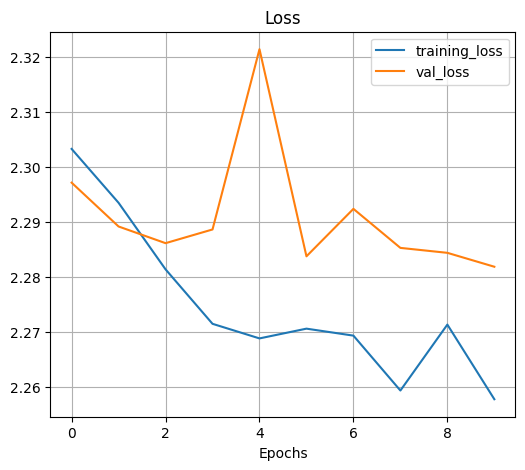

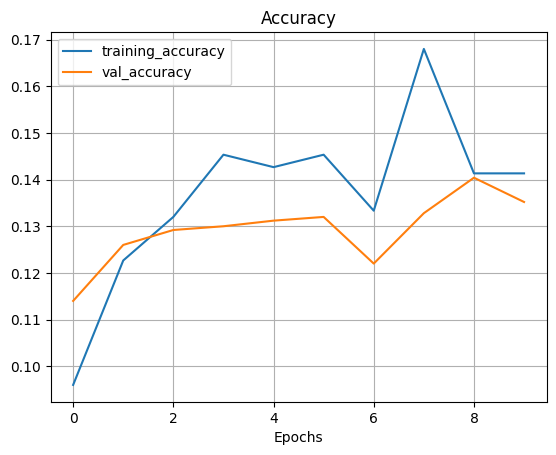

In [6]:
plot_loss_curves(lstm_history)

In [4]:
import tensorflow as tf
from tensorflow.keras import layers, models

def create_rnn_image_model(input_shape, num_classes):
    model = models.Sequential()

    model.add(layers.Reshape((input_shape[0] * input_shape[1], input_shape[2]), input_shape=input_shape))

    # Vanilla RNN layer
    model.add(layers.SimpleRNN(128, activation='relu'))

    # Dense layers for classification
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(num_classes, activation='softmax'))

    return model

tmp = create_rnn_image_model((224, 224, 3), 10)
tmp.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape (Reshape)           (None, 50176, 3)          0         
                                                                 
 simple_rnn (SimpleRNN)      (None, 128)               16896     
                                                                 
 dense (Dense)               (None, 128)               16512     
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 10)                1290      
                                                                 
Total params: 34698 (135.54 KB)
Trainable params: 34698 (135.54 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [6]:
import tensorflow as tf
from tensorflow.keras import layers, models

# Define the vanilla RNN-based model for image classification
def create_rnn_image_model(input_shape, num_classes):
    model = models.Sequential()

    model.add(layers.Reshape((input_shape[0] * input_shape[1], input_shape[2]), input_shape=input_shape))

    # Vanilla RNN layer
    model.add(layers.SimpleRNN(128, activation='relu'))

    # Dense layers for classification
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(num_classes, activation='softmax'))

    return model

# Define the input shape and number of classes
input_shape = (224, 224, 3)
num_classes = 10  # Replace with the number of classes in your dataset

# Create the vanilla RNN model for image classification
rnn_model = create_rnn_image_model(input_shape, num_classes)

# Compile the model
rnn_model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Display the model summary
rnn_history = rnn_model.fit(train_data_10_percent,
                epochs=5,
                steps_per_epoch=len(train_data_10_percent),
                validation_data=test_data,
                validation_steps=len(test_data))

Epoch 1/5
24/24 [==============================] - 508s 21s/step - loss: 2.3103 - accuracy: 0.1067 - val_loss: 2.2993 - val_accuracy: 0.1140
Epoch 2/5
24/24 [==============================] - 482s 21s/step - loss: 2.2939 - accuracy: 0.1307 - val_loss: 2.2959 - val_accuracy: 0.1092
Epoch 3/5
24/24 [==============================] - 484s 21s/step - loss: 2.2970 - accuracy: 0.1267 - val_loss: 2.2965 - val_accuracy: 0.1224
Epoch 4/5
24/24 [==============================] - 484s 21s/step - loss: 2.2947 - accuracy: 0.1320 - val_loss: 2.2939 - val_accuracy: 0.1224
Epoch 5/5
24/24 [==============================] - 484s 21s/step - loss: 2.2820 - accuracy: 0.1413 - val_loss: 2.2941 - val_accuracy: 0.1188


In [8]:
X_test, y_test = test_data.next()
evaluate_classification_metrics(y_test.argmax(axis=1), rnn_model.predict(X_test).argmax(axis=1))

1/1 [==============================] - 7s 7s/step


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'Accuracy': 0.125,
 'Precision': 0.07500000000000001,
 'Recall': 0.125,
 'F1 Score': 0.09375}

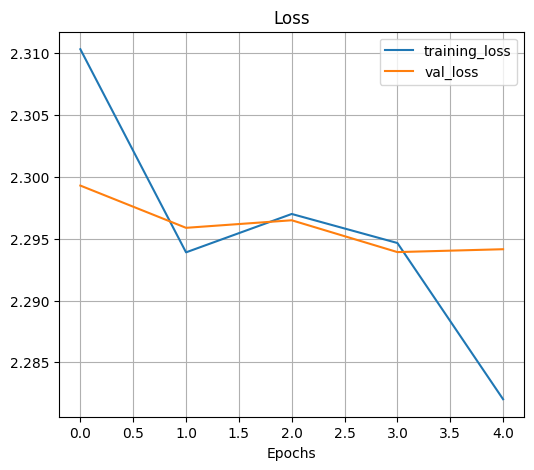

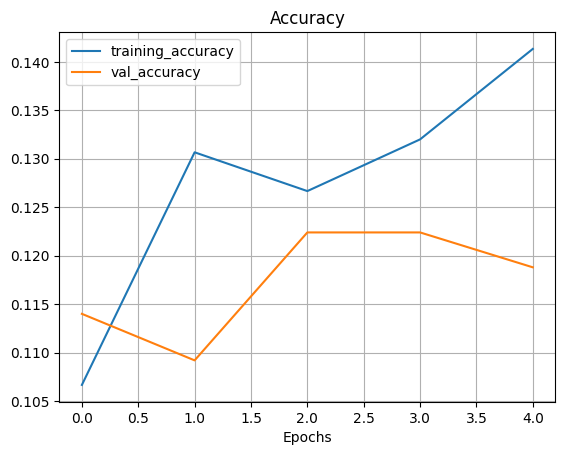

In [9]:
plot_loss_curves(rnn_history)

In [9]:
import tensorflow as tf
from tensorflow.keras import layers

class TransformerBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super(TransformerBlock, self).__init__()
        self.att = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = tf.keras.Sequential(
            [layers.Dense(ff_dim, activation="relu"), layers.Dense(embed_dim),]
        )
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)

    def call(self, inputs, training):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

# Define the model
inputs = layers.Input(shape=(224, 224, 3))
x = layers.Conv2D(32, 3, activation="relu")(inputs)
x = layers.MaxPooling2D()(x)
x = layers.Conv2D(64, 3, activation="relu")(x)
x = layers.MaxPooling2D()(x)
x = layers.Reshape((-1, 64))(x)
x = TransformerBlock(64, 2, 32)(x)
x = layers.GlobalAveragePooling1D()(x)
x = layers.Dense(64, 'relu')(x)
outputs = layers.Dense(10, activation="softmax")(x)

transformer_model = tf.keras.Model(inputs=inputs, outputs=outputs)

# Compile the model
transformer_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
transformer_history = transformer_model.fit(train_data_10_percent,
                      epochs=10,
                      steps_per_epoch=len(train_data_10_percent),
                      validation_data=test_data,
                      validation_steps=len(test_data))

X_test, y_test = test_data.next()
evaluate_classification_metrics(y_test.argmax(axis=1), transformer_model.predict(X_test).argmax(axis=1))

Epoch 1/10
24/24 [==============================] - 53s 1s/step - loss: 2.3714 - accuracy: 0.1027 - val_loss: 2.3046 - val_accuracy: 0.1212
Epoch 2/10
24/24 [==============================] - 21s 878ms/step - loss: 2.3006 - accuracy: 0.1093 - val_loss: 2.2792 - val_accuracy: 0.1472
Epoch 3/10
24/24 [==============================] - 20s 840ms/step - loss: 2.2620 - accuracy: 0.1520 - val_loss: 2.2648 - val_accuracy: 0.1344
Epoch 4/10
24/24 [==============================] - 23s 983ms/step - loss: 2.2240 - accuracy: 0.1667 - val_loss: 2.2184 - val_accuracy: 0.1908
Epoch 5/10
24/24 [==============================] - 20s 834ms/step - loss: 2.2202 - accuracy: 0.1640 - val_loss: 2.2197 - val_accuracy: 0.1928
Epoch 6/10
24/24 [==============================] - 20s 843ms/step - loss: 2.1954 - accuracy: 0.1960 - val_loss: 2.1941 - val_accuracy: 0.2076
Epoch 7/10
24/24 [==============================] - 20s 848ms/step - loss: 2.1535 - accuracy: 0.1867 - val_loss: 2.1841 - val_accuracy: 0.2224
Ep

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'Accuracy': 0.34375,
 'Precision': 0.3638392857142857,
 'Recall': 0.34375,
 'F1 Score': 0.3200434981684982}

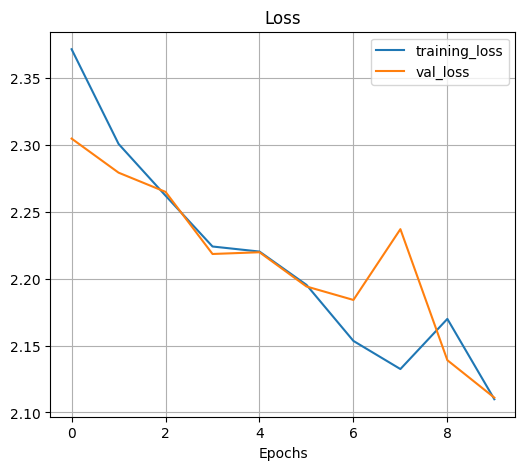

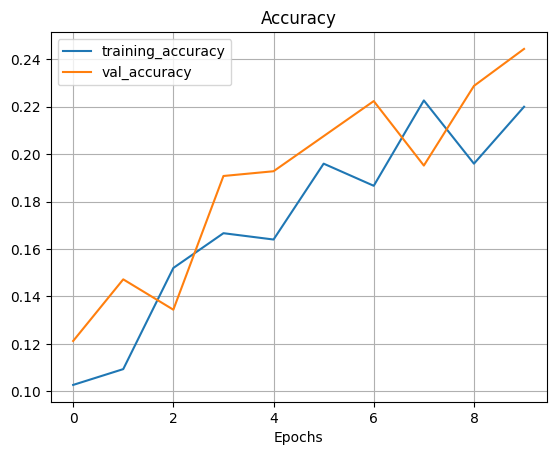

In [14]:
plot_loss_curves(transformer_history)

In [11]:
transformer_model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv2d_6 (Conv2D)           (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 111, 111, 32)      0         
 g2D)                                                            
                                                                 
 conv2d_7 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_7 (MaxPoolin  (None, 54, 54, 64)        0         
 g2D)                                                            
                                                                 
 reshape_4 (Reshape)         (None, 2916, 64)          0   